In [1]:
import torch, torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install opencv-python-headless

In [4]:
import zipfile
import os

# Path to the zip file (can be a path in your Colab environment or from your Drive)
zip_file_path = '/content/drive/MyDrive/Train_Spects.zip'

# Destination folder where the contents will be extracted
destination_folder = '/content/drive/MyDrive/Dataset/'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f'Contents extracted to {destination_folder}')


Contents extracted to /content/drive/MyDrive/Dataset/


In [57]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [58]:
train_folders = sorted(glob('/content/drive/MyDrive/Dataset/Train_Spects/*'))
len(train_folders)

7

In [59]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [60]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in train_folders]
show_sign_grid(sample_images)

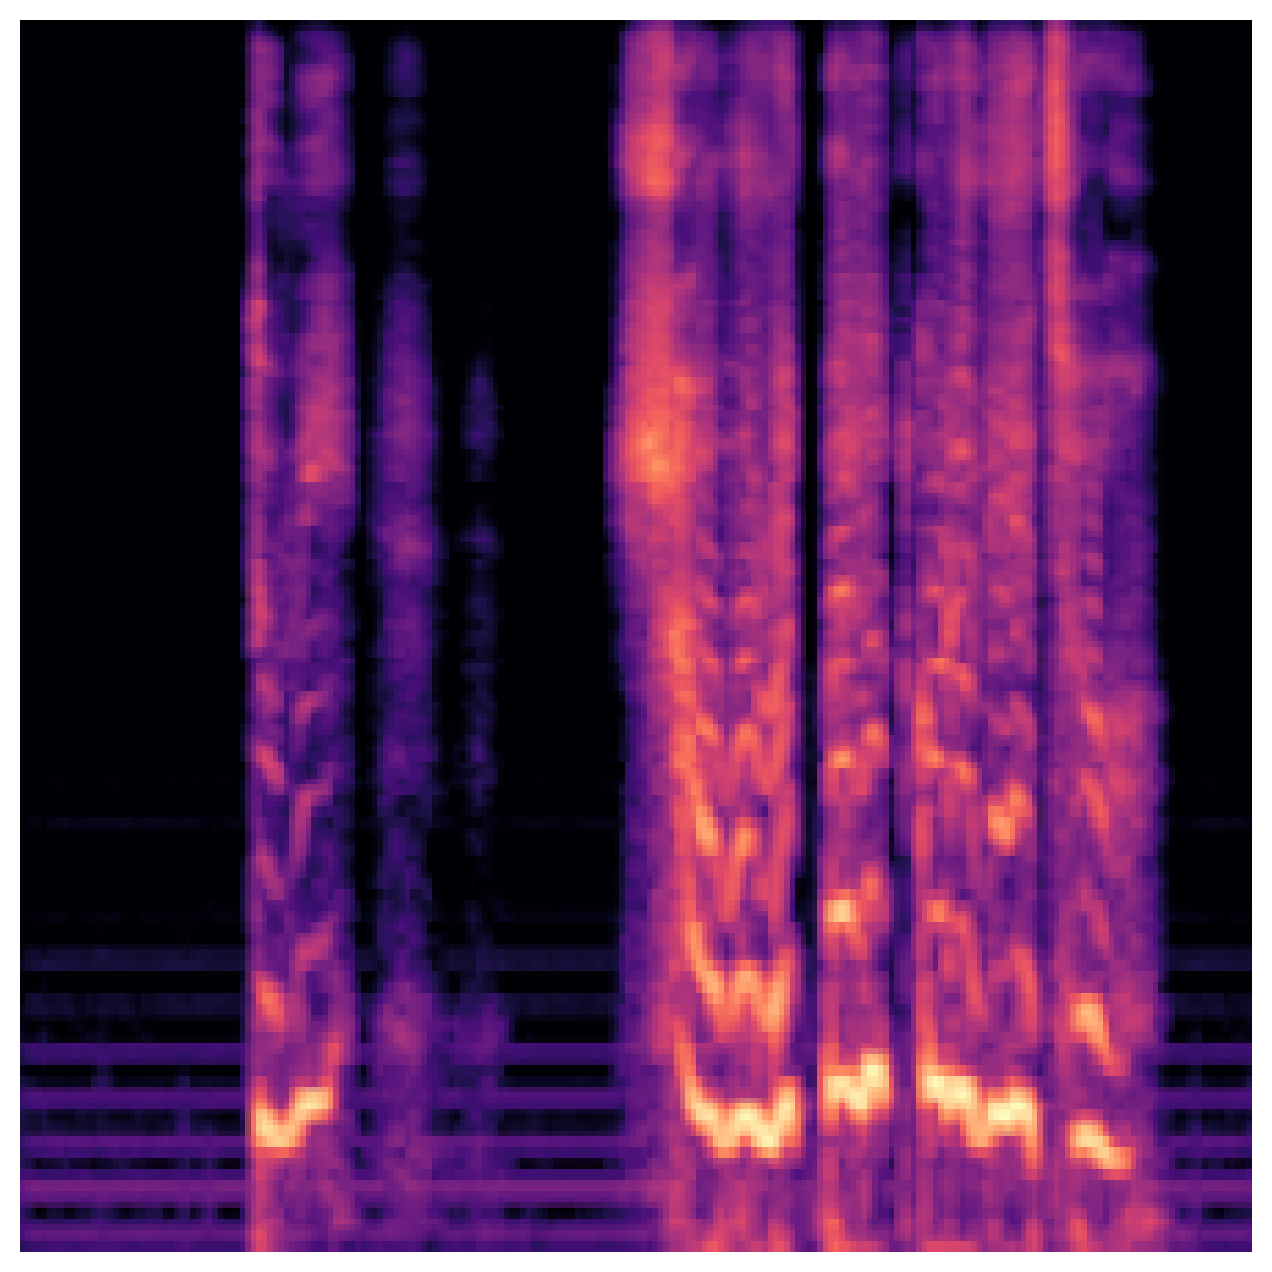

In [61]:
img_path = glob(f'{train_folders[2]}/*png')[20]

show_image(img_path)

In [62]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [65]:
import subprocess
command = "rm -rf data"
subprocess.run(command, shell=True)

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [66]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths))] #Data Split Ratio here:
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Angry: 2710
Disgust: 2160
Fear: 1800
Happy: 2710
Neutral: 2416
Sad: 2710
Surprise: 2350


In [67]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [68]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=32, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [69]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 13484, 'val': 3372}

In [70]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [71]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5]):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    n_features = model.fc.in_features
    model.fc = nn.Sequential(
        ResidualBlock(n_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes)
    )

    return model.to(device)

In [72]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.6MB/s]


In [73]:
#base_model.classifier[-1]

In [74]:
#IN_FEATURES = base_model.classifier[-1].in_features

#final_fc = nn.Linear(IN_FEATURES,len(class_names) )

In [75]:
#base_model.classifier[-1] = final_fc

In [77]:
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [78]:
base_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [79]:
from tqdm.notebook import tqdm

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  batch_progress = tqdm(data_loader, desc='Training', leave=False)

  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    batch_progress.set_postfix(loss=np.mean(losses), accuracy=(correct_predictions.double() / n_examples).item())
    batch_progress.update(1)
  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [80]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  batch_progress = tqdm(data_loader, desc='Evaluation', leave=False)
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      batch_progress.set_postfix(loss=np.mean(losses), accuracy=(correct_predictions.double() / n_examples).item())
      batch_progress.update(1)

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#pip install tqdm

In [81]:
from tqdm import tqdm

def train_model(model, data_loaders, dataset_sizes, device, n_epochs=12): #Epoch
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')

  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [82]:
%%time
#224*224
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/12
----------


Train loss 1.4639699048058117 accuracy 0.4144912488875705


Val   loss 0.9358901353377216 accuracy 0.6500593119810202

Epoch 2/12
----------


Train loss 0.7847000900038046 accuracy 0.7045387125482053


Val   loss 0.7881985939336273 accuracy 0.704626334519573

Epoch 3/12
----------


Train loss 0.47253068797819986 accuracy 0.823568673983981


Val   loss 0.5449379952448719 accuracy 0.8051601423487545

Epoch 4/12
----------


Train loss 0.26938762538735334 accuracy 0.9056659744882825


Val   loss 0.4514605203327143 accuracy 0.8454922894424675

Epoch 5/12
----------


Train loss 0.1858679033392131 accuracy 0.9358498961732424


Val   loss 0.4171279980186022 accuracy 0.8561684460260973

Epoch 6/12
----------


Train loss 0.1236923041541606 accuracy 0.9580984870958174


Val   loss 0.32962292808828486 accuracy 0.8967971530249111

Epoch 7/12
----------


Train loss 0.10125338558937419 accuracy 0.9658854939187186


Val   loss 0.5124203115701675 accuracy 0.8629893238434164

Epoch 8/12
----------


Train loss 0.04783626630575665 accuracy 0.9844259863541976


Val   loss 0.2280952025661772 accuracy 0.92497034400949

Epoch 9/12
----------


Train loss 0.02226658887478139 accuracy 0.9949569860575498


Val   loss 0.2101026836360963 accuracy 0.930308422301305

Epoch 10/12
----------


Train loss 0.019389005033056565 accuracy 0.9956986057549689


Val   loss 0.20421979727469525 accuracy 0.9309015421115066

Epoch 11/12
----------


Train loss 0.016134513741162145 accuracy 0.9962919015129043


Val   loss 0.20413575836299164 accuracy 0.9338671411625149

Epoch 12/12
----------


Train loss 0.011463893868701678 accuracy 0.9981459507564522


Val   loss 0.19790797686766623 accuracy 0.9377224199288257

Best val accuracy: 0.9377224199288257
CPU times: user 41min 49s, sys: 2min 17s, total: 44min 6s
Wall time: 1h 20min 41s


In [83]:
checkpoint_path = "/content/drive/MyDrive/res50.pth"
torch.save(base_model.state_dict(), checkpoint_path)

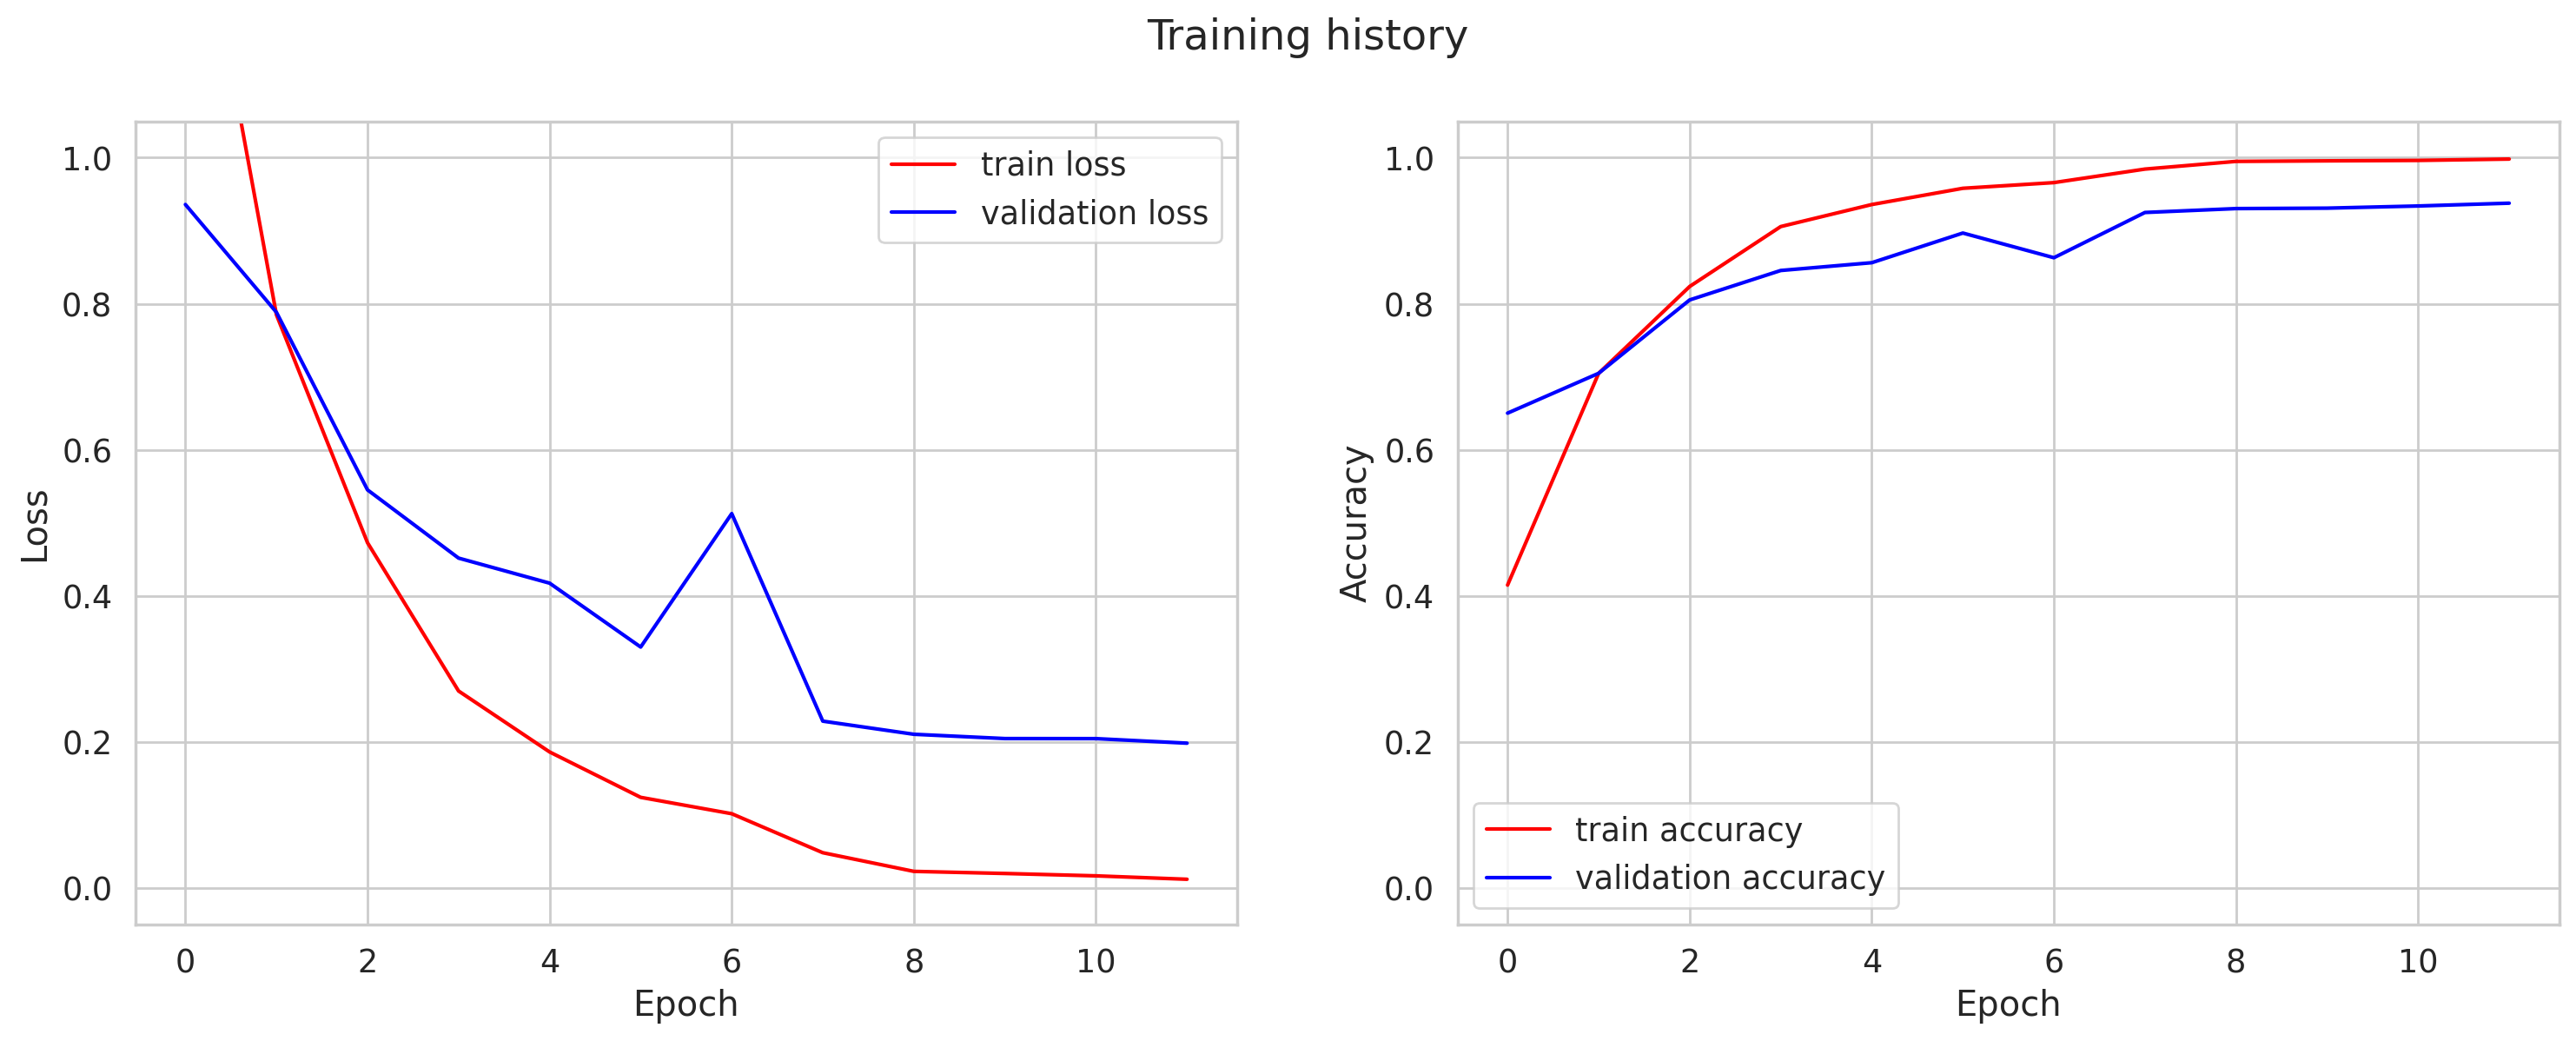

In [86]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history['train_loss'], label='train loss', color ='red')
    ax1.plot(history['val_loss'], label='validation loss', color = 'blue')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    # Move the tensors to the CPU and convert to NumPy arrays
    train_acc = [x.cpu().numpy() for x in history['train_acc']]
    val_acc = [x.cpu().numpy() for x in history['val_acc']]
    # train_acc = [x for x in history['train_acc']]
    # val_acc = [x for x in history['val_acc']]

    ax2.plot(train_acc, label='train accuracy',color ='red')
    ax2.plot(val_acc, label='validation accuracy',color ='blue')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training history')

plot_training_history(history)

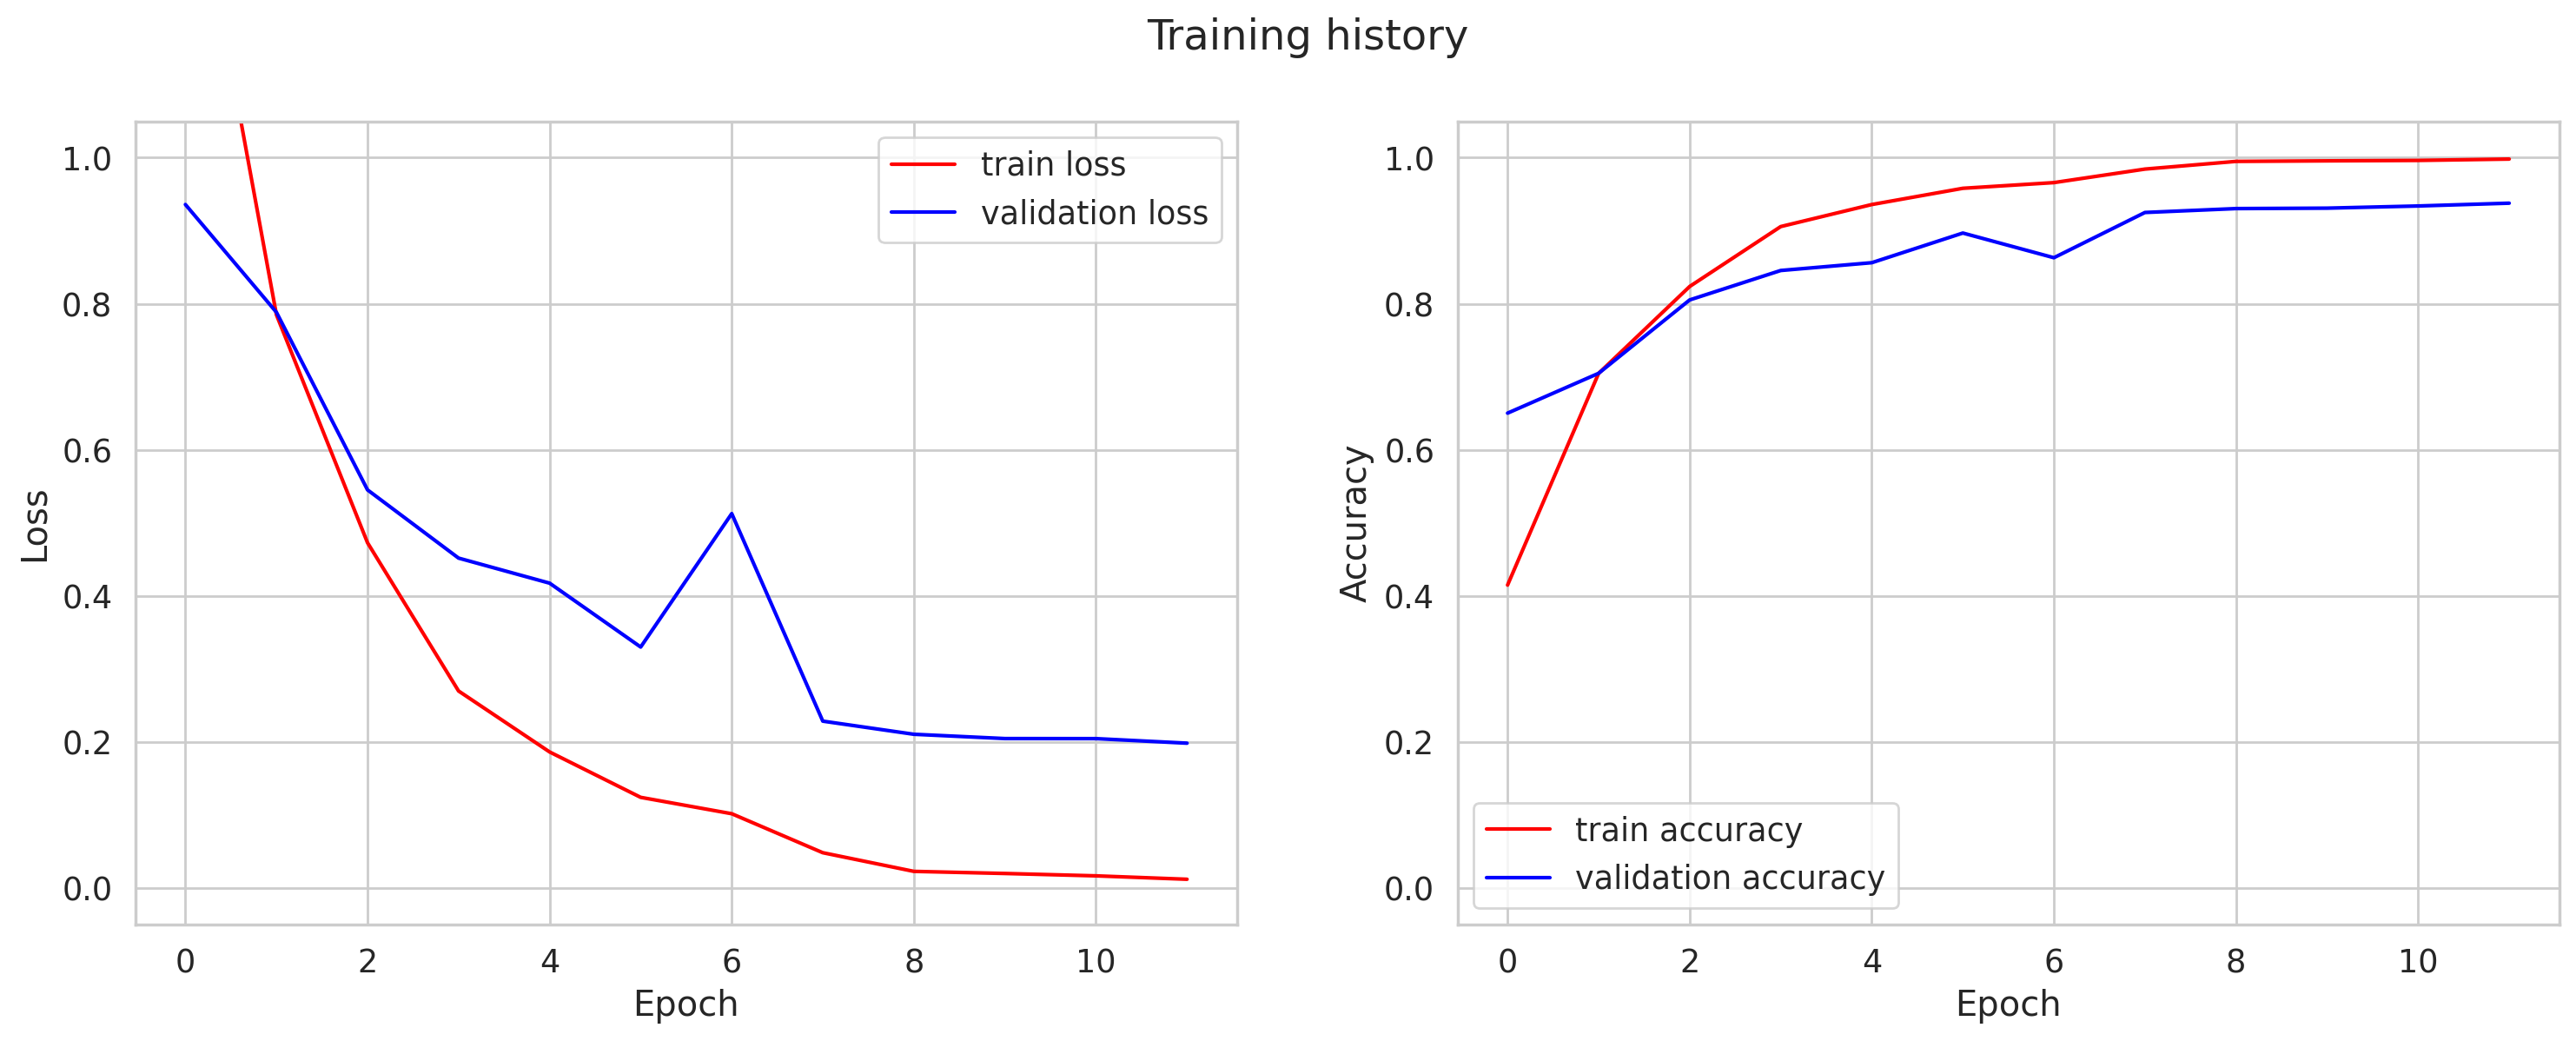

In [87]:
#224*224
plot_training_history(history)

# **Test Data**(unseen)

In [88]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

In [89]:
test_folders = sorted(glob('/content/drive/MyDrive/Dataset/Test_Spects/*'))
len(test_folders)
#E:/Thesis/Seg2_test_set_classified/0-25/* done
#E:/Thesis/Seg2_test_set_classified/25-50/* done
#E:/Thesis/Seg2_test_set_classified/50plus/* done
#E:/Thesis/Seg2_test_set/*

7

In [91]:
base_model = create_model(len(class_names))
#base_model.classifier[-1]
#IN_FEATURES = base_model.classifier[-1].in_features

#final_fc = nn.Linear(IN_FEATURES,len(class_names) )
#base_model.classifier[-1] = final_fc
#print(base_model.classifier)

checkpoint_path = "/content/drive/MyDrive/res50.pth"
checkpoint = torch.load(checkpoint_path)

base_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
base_model.to(device)
base_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [92]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

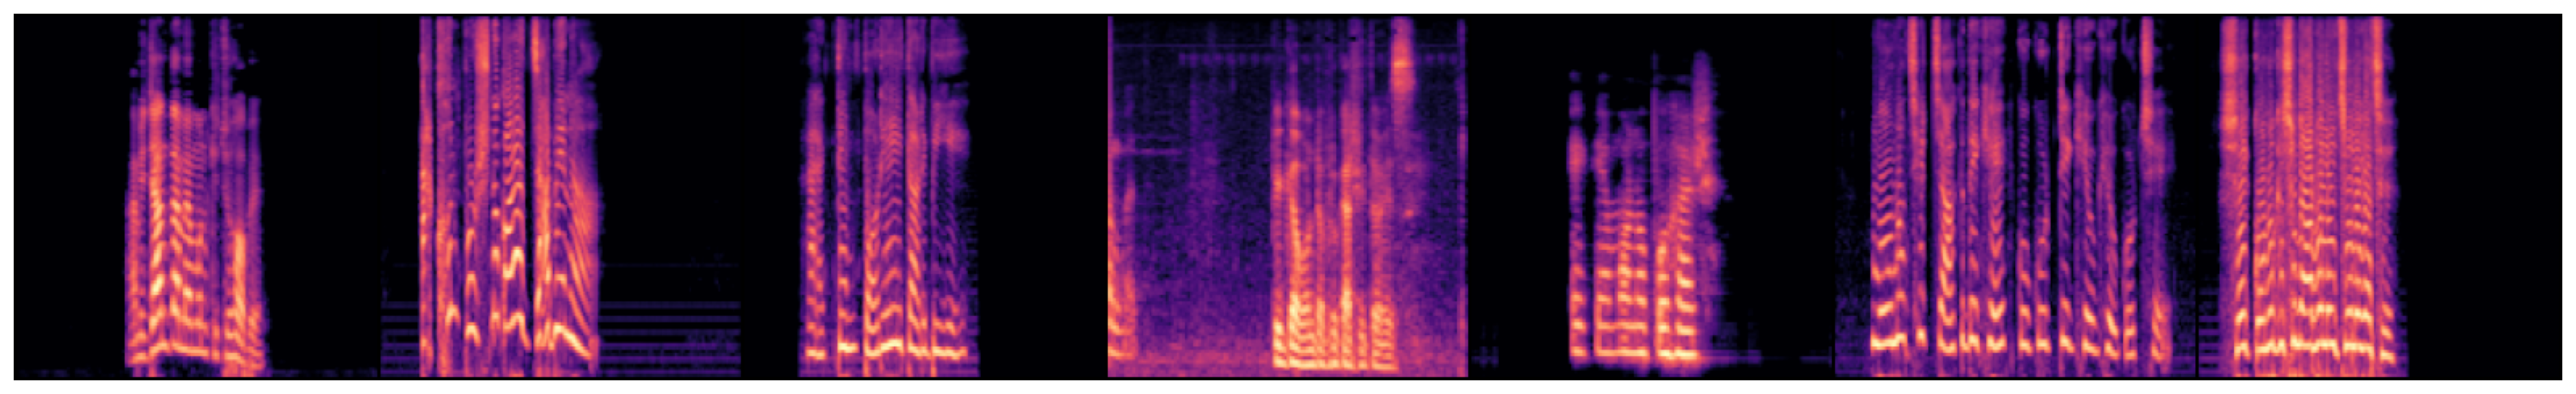

In [93]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

In [94]:
img_path = glob(f'{test_folders[2]}/*png')[1]

show_image(img_path)

In [95]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [96]:
import subprocess
command = "rm -rf data"
subprocess.run(command, shell=True)

DATA_DIR = Path('test_data')

DATASETS = ['test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [97]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Angry: 151
Disgust: 120
Fear: 100
Happy: 151
Neutral: 135
Sad: 151
Surprise: 131


In [98]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [99]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=5, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [100]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 939}

In [101]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [102]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20,10))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}\n'  f'true: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

In [103]:
show_predictions(base_model, class_names, n_images=8)

In [104]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [105]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [106]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.91      0.88      0.90       151
     Disgust       0.85      0.82      0.83       120
        Fear       0.94      0.97      0.96       100
       Happy       0.91      0.83      0.87       151
     Neutral       0.88      0.99      0.93       135
         Sad       0.87      0.90      0.88       151
    Surprise       0.92      0.91      0.92       131

    accuracy                           0.90       939
   macro avg       0.90      0.90      0.90       939
weighted avg       0.90      0.90      0.89       939



In [107]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

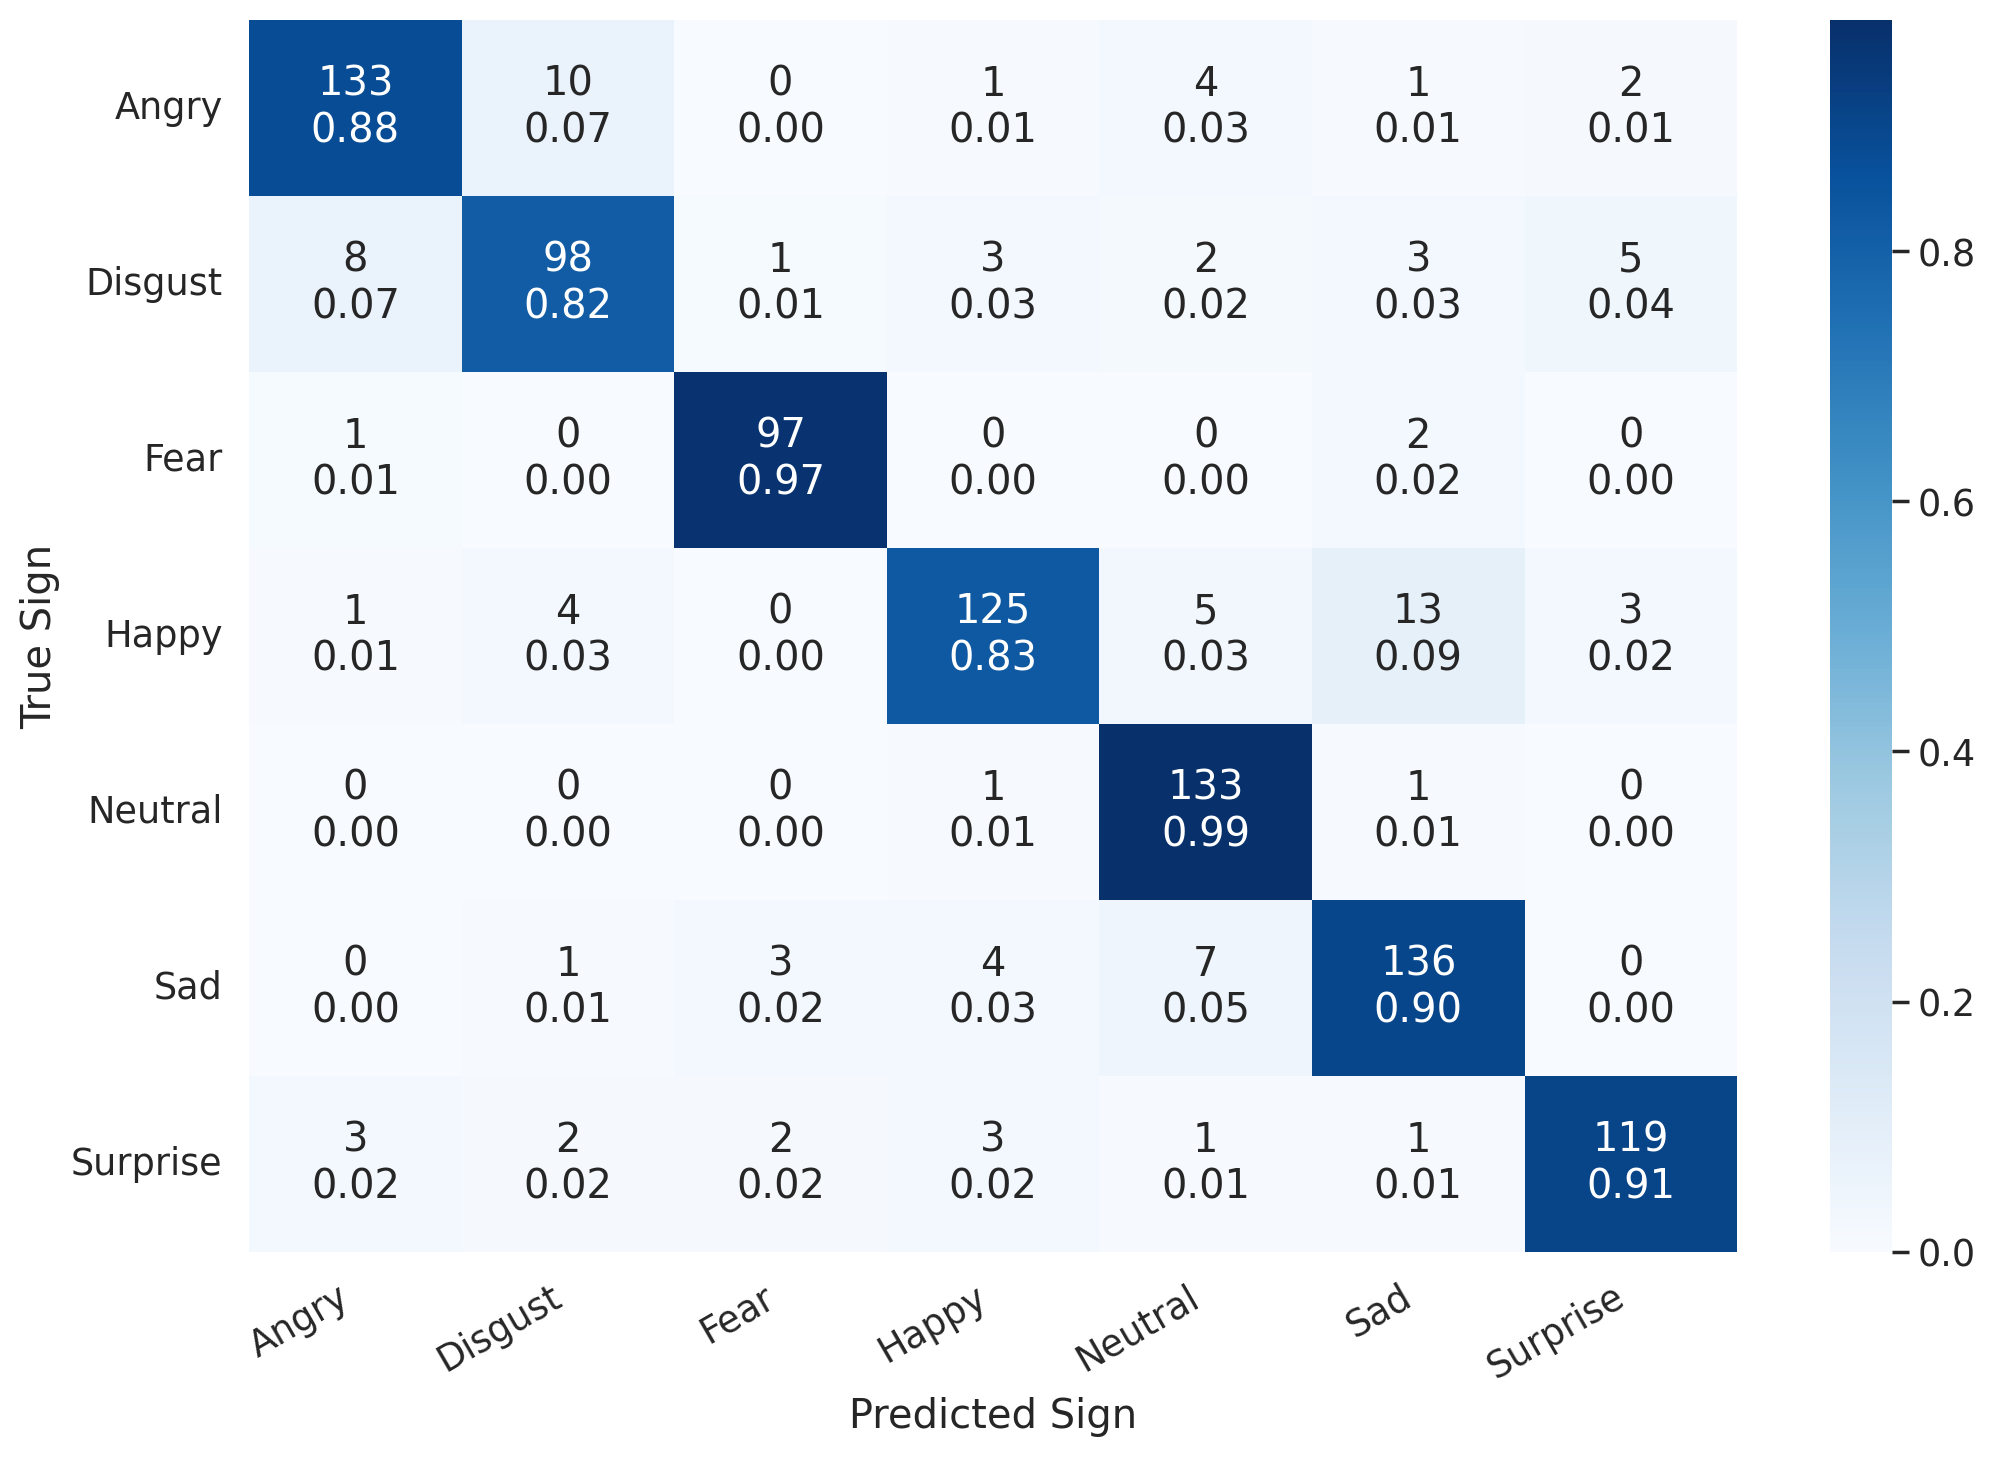

In [108]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)